# **PARSING AND DERIVING CLOUD MASKS & MULTISPECTRAL DATA FROM GOES-16,17 DATA IN .nc FORMAT**

## IMPORT ALL REQUIRED LIBS AND DEFINE YOUR CURRENT DIRECTORY

In [1]:
import tifffile as tff
from timeit import default_timer as timer 
import pvlib
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import gc
import os
import patoolib
import warnings
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pyproj
from rasterio.warp import reproject, Resampling
import rasterio
from skimage.transform import resize as interp_resize
import netCDF4 as nc
%matplotlib inline
warnings.filterwarnings("ignore")

### **UNARCHIVE ALL DATA FROM THIS REPO: SNOW MAP, ASTER GDEM & LON, LAT OF GOES-16,17;**
**AFTER THAT SELECT NEEDED SATELLITE: GOES_16 or GOES_17 (GOES_16_mode or GOES_17_mode)**


In [18]:
#unrar ar archieved data
your_current_dir = os.getcwd()
print('Your current dir of this .ipynb file',your_current_dir)
GOES_16_mode = True
GOES_17_mode = False
for name in os.listdir(your_current_dir):
    if name.endswith('.rar'):
        try:
            patoolib.extract_archive(your_current_dir+'/'+name, outdir=your_current_dir+'/')
            clear_output()
        except:
            print('YOU ALREADY UNARCHIVED THIS DATA')
if GOES_16_mode:       
    for name in os.listdir(your_current_dir+'/GOES_16'):
        if name.endswith('.rar'):
            try:
                patoolib.extract_archive(your_current_dir+'/GOES_16/'+name, outdir=your_current_dir+'/GOES_16/')
                clear_output()
            except:
                print('YOU ALREADY UNARCHIVED THIS DATA')
if GOES_17_mode:
    for name in os.listdir(your_current_dir+'/GOES_17'):
        if name.endswith('.rar'):
            try:
                patoolib.extract_archive(your_current_dir+'/GOES_17/'+name, outdir=your_current_dir+'/GOES_17/')
                clear_output()
            except:
                print('YOU ALREADY UNARCHIVED THIS DATA')


Your current dir of this .ipynb file C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data
patool: Extracting C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data/GDEM-10km-BW.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data\GDEM-10km-BW.rar
patool:     with cwd=C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data/
YOU ALREADY UNARCHIEVED THIS DATA
patool: Extracting C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data/snow_2022_10_15.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data\snow_2022_10_15.rar
patool:     with cwd=C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES_data/
YOU ALREADY UNARCHIEVED THIS DATA
patool: Extracting C:\Users\nikita.belyakov\Documents\GitHub\CLOUD_SNOW_SEGMENTATION\GOES

**THIS FUNCTION MAKES A HORIZONTAL & VERTICAL SHIFT OF IMAGE - MAYBE USEFULL TO CORRECT MASKS OR DEM AFTER REPROJECTION**

In [8]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

## **NEXT YOU SHOULD DOWNLOAD CLEAR_SKY AND CLOUD_MOISTURE L2 PRODUCT OF GOES-R FROM HERE: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi**

- You should choose 'FULL DISK' format
- Download multispectral data (ABI L2 Cloud & Moisture Imagery) in multiband format - it's easier to parse
- Cloud masks is the ABI L2 Clear Sky Mask product

### **PARSEING GOES-16 DATA: CLOUD MASKS (CLEAR SKY) AT FIRST**

[  0 255]


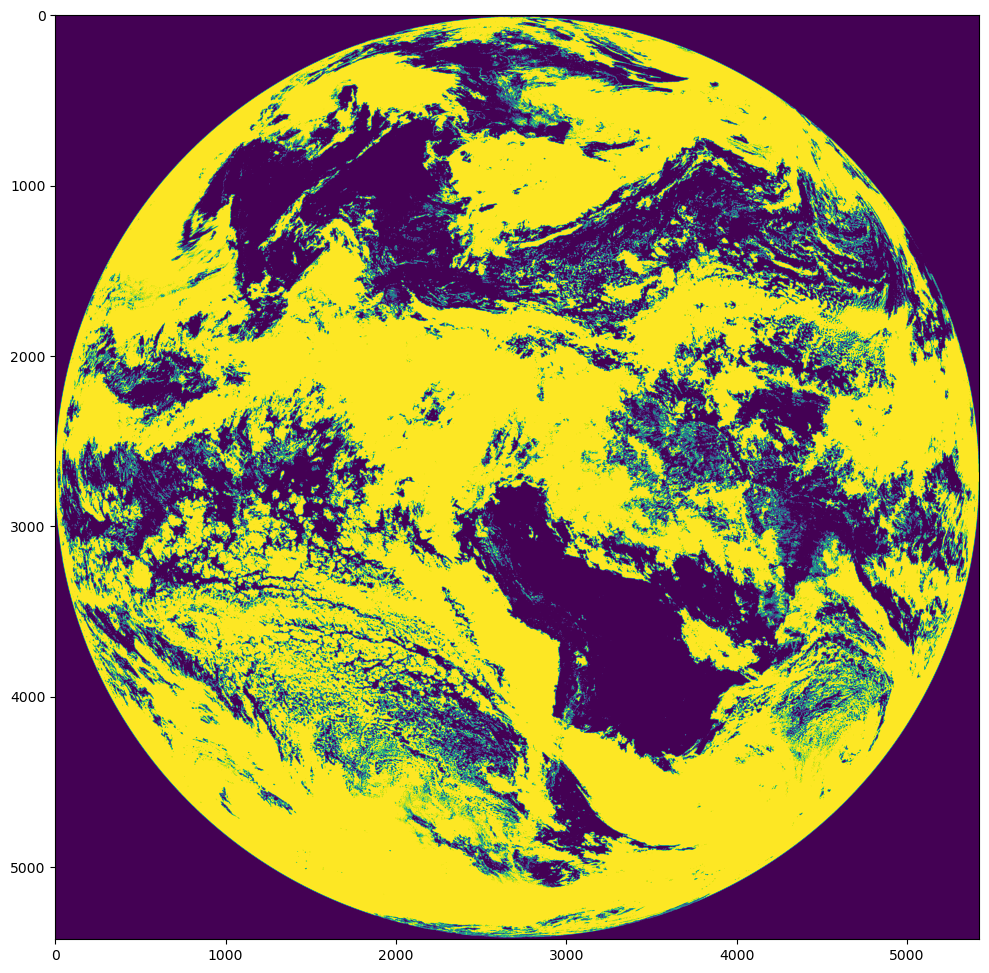

In [11]:
# Download files at this link: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi
save_mode = False
if GOES_16_mode:       
    for name in os.listdir(your_current_dir+'/GOES_16'):
        if 'ACM' in name:
            clear_sky_path = your_current_dir+'/GOES_16/'+name
if GOES_17_mode:       
    for name in os.listdir(your_current_dir+'/GOES_17'):
        if 'ACM' in name:
            clear_sky_path = your_current_dir+'/GOES_17/'+name
file = Dataset(clear_sky_path)
DQF = np.array(file.variables['DQF'])
BCM = np.array(file.variables['BCM'])
BCM[BCM==255]=0
BCM = (BCM*255).astype(np.uint8)
DQF_unint = DQF.copy()
DQF_unint[DQF_unint==0]=1
DQF_unint[DQF_unint!=1]=0
cloud_probs_thr = (BCM*DQF_unint).astype(np.uint8)
plt.figure(figsize=(12,12))
# Plot the image
if save_mode:
    tff.imwrite(clear_sky_path.replace('.nc', '.jpg'),BCM)
plt.imshow(cloud_probs_thr)
#----------------------------------------------------------------------------------------------------------- 
# Show the image
plt.show()

### **NEXT PROCESS GOES MULTISPECTRAL DATA FROM L2 CLOUD_MOISTURE PRODUCT**

BT and RGB successfully saved as .tif files!


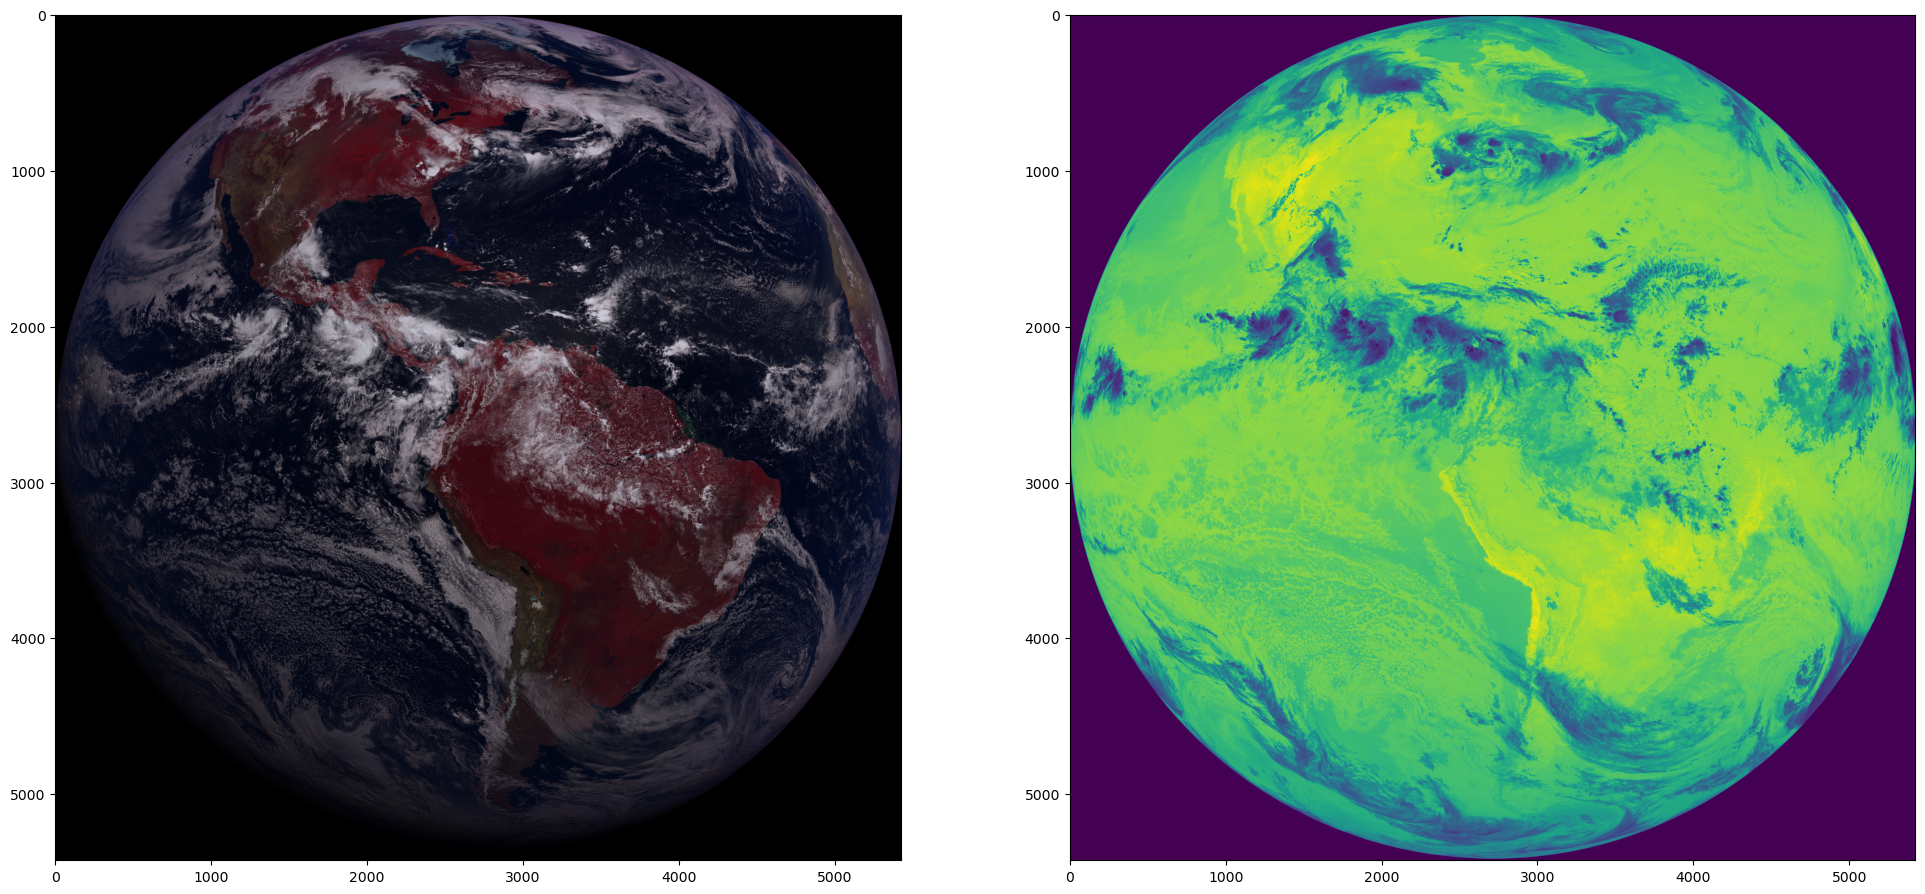

In [28]:
if GOES_16_mode:    
    save_dir = your_current_dir+'/GOES_16'
    for name in os.listdir(your_current_dir+'/GOES_16'):
        if 'MIPF' in name:
            mss_path = your_current_dir+'/GOES_16/'+name
if GOES_17_mode:       
    save_dir = your_current_dir+'/GOES_17'
    for name in os.listdir(your_current_dir+'/GOES_17'):
        if 'MIPF' in name:
            mss_path = your_current_dir+'/GOES_17/'+name
normalize_BT_mode = True
rad2rgb_mode = True
resize_mode_1_km = False
save_mode = True
fil = Dataset(mss_path)
data_vars = fil.variables
b,g,r = np.array(fil.variables['CMI_C01']), np.array(fil.variables['CMI_C02']),np.array(fil.variables['CMI_C03'])
BT4 = np.array(fil.variables['CMI_C07'])
BT5 = np.array(fil.variables['CMI_C08'])
BT6 = np.array(fil.variables['CMI_C09'])
BT7 = np.array(fil.variables['CMI_C11'])
BT8 = np.array(fil.variables['CMI_C13'])
BT9 = np.array(fil.variables['CMI_C14'])
# fill borders with zeros
BT4[BT4==BT4[0,0]]=0
BT5[BT5==BT5[0,0]]=0
BT6[BT6==BT6[0,0]]=0
BT7[BT7==BT7[0,0]]=0
BT8[BT8==BT8[0,0]]=0
BT9[BT9==BT9[0,0]]=0
min_BT4,min_BT5,min_BT6,min_BT7,min_BT8,min_BT9 =np.unique(BT4)[1],np.unique(BT5)[1],np.unique(BT6)[1],np.unique(BT7)[1],np.unique(BT8)[1],np.unique(BT9)[1]
r_min, g_min, b_min = 0,0,0 
b_border = b[0,0]
g_border = g[0,0]
r_border = r[0,0]
b[b==b_border]=0
g[g==g_border]=0
r[r==r_border]=0
if rad2rgb_mode:
    r_normed = (r - r_min)/(np.max(r)-r_min)
    g_normed = (g - g_min)/(np.max(g)-g_min)
    b_normed = (b - b_min)/(np.max(b)-b_min)
    b_border = b_normed[0,0]
    g_border = g_normed[0,0]
    r_border = r_normed[0,0]
    b_normed[b_normed==b_border]=0
    g_normed[g_normed==g_border]=0
    r_normed[r_normed==r_border]=0
rgb = np.dstack([r_normed,g_normed,b_normed])
rgb = (rgb*255.).astype(np.uint8)
if normalize_BT_mode:
    BT4 = (BT4-min_BT4)/(np.max(BT4)-min_BT4)
    BT5 = (BT5-min_BT5)/(np.max(BT5)-min_BT5)
    BT6 = (BT6-min_BT6)/(np.max(BT6)-min_BT6)
    BT7 = (BT7-min_BT7)/(np.max(BT7)-min_BT7)
    BT8 = (BT8-min_BT8)/(np.max(BT8)-min_BT8)
    BT9 = (BT9-min_BT9)/(np.max(BT9)-min_BT9)
    BT4 = np.clip(BT4, 0,1)
    BT5 = np.clip(BT5, 0,1)
    BT6 = np.clip(BT6, 0,1)
    BT7 = np.clip(BT7, 0,1)
    BT8 = np.clip(BT8, 0,1)
    BT9 = np.clip(BT9, 0,1)
if resize_mode_1_km:
    r_normed = interp_resize(r_normed, (10848,10848))
    g_normed = interp_resize(g_normed, (10848,10848))
    b_normed = interp_resize(b_normed, (10848,10848))
    BT4 = interp_resize(BT4, (10848,10848))
    BT5 = interp_resize(BT5, (10848,10848))
    BT6 = interp_resize(BT6, (10848,10848))
    BT7 = interp_resize(BT7, (10848,10848))
    BT8 = interp_resize(BT8, (10848,10848))
    BT9 = interp_resize(BT9, (10848,10848))
BT = np.dstack([BT4, BT5, BT6, BT7, BT8, BT9])
if save_mode:
    tff.imsave(save_dir+'/BT.tif',BT)
    tff.imsave(save_dir+'/rgb.tif',rgb)
    print('BT and RGB successfully saved as .tif files!')
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(rgb)
ax[1].imshow(BT8)
plt.show()
# clear memory
r,g,b,rgb,r_normed,g_normed,b_normed = None,None,None,None,None,None,None
BT,BT4,BT5,BT6,BT7,BT8,BT9 = None,None,None,None,None,None,None

### **APPLY ZENITH SOLAR CORRECTION FOR RGB IMAGE TO REDUCE SHADOWS**

- You should input correct time in UTC format to find Zenith Solar angles for each pixels of image according its lonlat coordinates
- You should input correct satellite position as well: lat = 0 by default for geostationary orbits
- GOES-16 longitude can be set as -76.0
- GOES-17 longitude can be set as -137.0
- def ZSA_for_full_image requires lat and lon of full image, its loaded as numpy matrixes from GOES_data folder
- def ZSA_for_full_image requires out dir for saving ZSA cos matrix and corrected RGB image
- **ATTENTION!** def ZSA_for_full_image for image with size (5424,5424) with 2 km resolution works long - **around  10 minutes - be patient!**

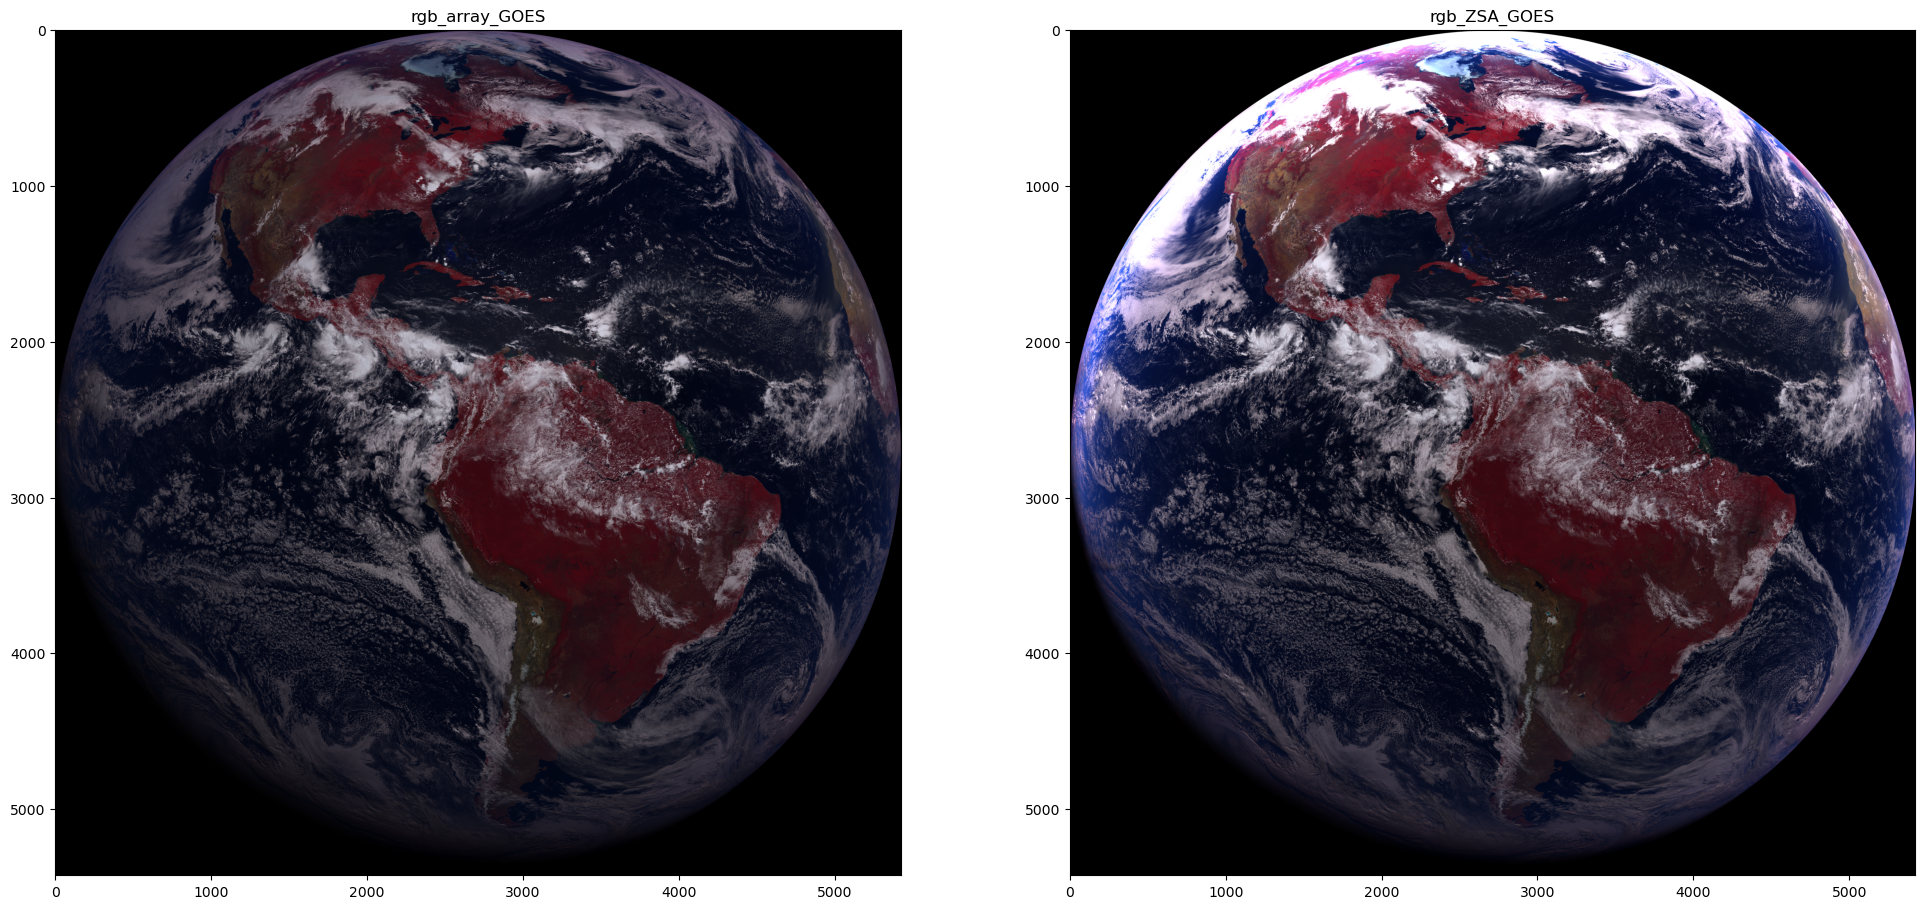

time spent for ZSA correction (seconds): 641.0538646999994


In [32]:
def ZSA_for_full_image(rgb_array,lats, lons, time, sat_lon, out_dir, save_flag = False):
    # Define the longitude and latitude ranges
    rgb_shape = rgb_array.shape[0]
    out_file = out_dir + 'rgb_ZSA.jpg'
    # Define the location
    # create a Location object with the specified coordinates
    location = pvlib.location.Location(lats.flatten(), lons.flatten())
    times = np.array([time for i in range(len(lons.flatten()))])
    # calculate the solar position for the specified time and location
    solar_position = location.get_solarposition(times)
    # calculate the zenith angle for each pixel
    zenith_angle = solar_position['apparent_zenith'].values
    zenith_angle = np.clip(zenith_angle, 0.0, 80.0) # clip to avoid angles close to 90 and division by zero!
    zenith_angle_rad = np.deg2rad(zenith_angle)
    # Calculate the cosine of the zenith angle for all pixels
    cos_zenith_angle = np.cos(zenith_angle_rad)
    cos_zenith_angles = cos_zenith_angle.reshape(rgb_shape,rgb_shape)
    # Apply the correction to the satellite image
    corrected_sat_image = rgb_array / cos_zenith_angles[:, :, np.newaxis]
    corrected_sat_image = np.clip(corrected_sat_image, 0, 255).astype(np.uint8)
    cos_zenith_angles_path = out_dir + 'ZSA_cos_2km_res.npy'
    if save_flag:
        np.save(cos_zenith_angles_path,cos_zenith_angles)
        tff.imsave(out_file,corrected_sat_image)
    return corrected_sat_image
if GOES_16_mode:
    lon_dir = your_current_dir+'\GOES_16'
    lat_dir = your_current_dir+'\GOES_16'
    rgb_dir = your_current_dir+'\GOES_16'
    out_dir = your_current_dir+'\GOES_16'
    sat_lon = -76.0
if GOES_17_mode:       
    lon_dir = your_current_dir+'/GOES_17'
    lat_dir = your_current_dir+'/GOES_17'
    rgb_dir = your_current_dir+'/GOES_17'
    out_dir = your_current_dir+'/GOES_17'
    sat_lon = -137.0
lat_goes = np.load(lat_dir + '/lats_goes_full_disk_2km_res.npy')
lon_goes = np.load(lon_dir + '/lon_goes_full_disk_2km_res.npy')
rgb_path = rgb_dir+'/rgb.tif'
rgb = tff.imread(rgb_path)
time = pd.Timestamp('2022-10-15 16:00:00') # input UTC time for satellite image
start = timer()
corrected_GOES_image = ZSA_for_full_image(rgb_array = rgb,lats=lat_goes, lons=lon_goes, time=time, sat_lon = sat_lon,out_dir = out_dir)
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(rgb)
ax[1].imshow(corrected_GOES_image)
ax[0].set_title('rgb_array_GOES')
ax[1].set_title('rgb_ZSA_GOES')
plt.show()
print('time spent for ZSA correction (seconds):',timer() - start)

## **OPEN ASTER GDEM ALTITUDE MAP & SNOW MAP from MODIS**

### NEXT YOU SHOULD DOWNLOAD SNOW MAP MODIS SNOW CENTER PRODUT FROM HERE:
https://neo.gsfc.nasa.gov/view.php?datasetId=MOD10C1_E_SNOW&date=2023-02-15

- it's better to download its daily map in maximum resolution 3600*1800
- it's more comfortable to work with reaster format => choose .tif raster color format before downloading
- fresh snow masks in rgb format can be also downloaded from here (**requires the other pipeline of processing to eval binary snow mask**): https://n5eil01u.ecs.nsidc.org/MOST/MOD10C1.061/2023.05.15/
- the cell below provides opening snow_map for 2022.10.15, alternatively, select your file name of snow file, downloaded from the first source above

[  0 255]


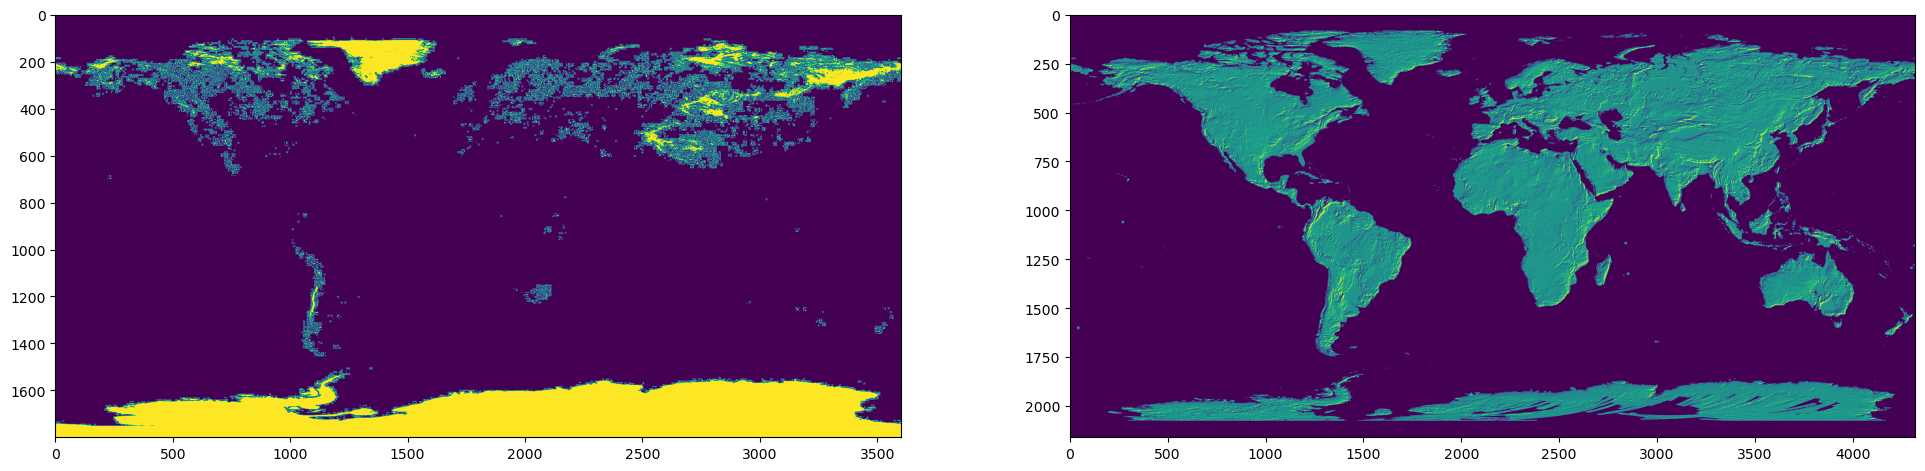

In [33]:
#open DEM and snow map from MODIS
alt_map_path = your_current_dir+'/GDEM-10km-BW.tif'
aster_gdem_map = rasterio.open(alt_map_path).read(1)
snow_map_path = your_current_dir+'/snow_2022_10_15.jpg'
snow_map = rasterio.open(snow_map_path).read(1)
snow_map[snow_map>254]=0
snow_map[snow_map>0]=255
print(np.unique(snow_map))
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(snow_map)
ax[1].imshow(aster_gdem_map)
plt.show()

### **Pipeline of processing to eval binary snow mask from this snow map source**
: https://n5eil01u.ecs.nsidc.org/MOST/MOD10C1.061/2023.05.15/
- This code cell can be applied to file from this source without changing its name
- You should download .hdf file from the source above

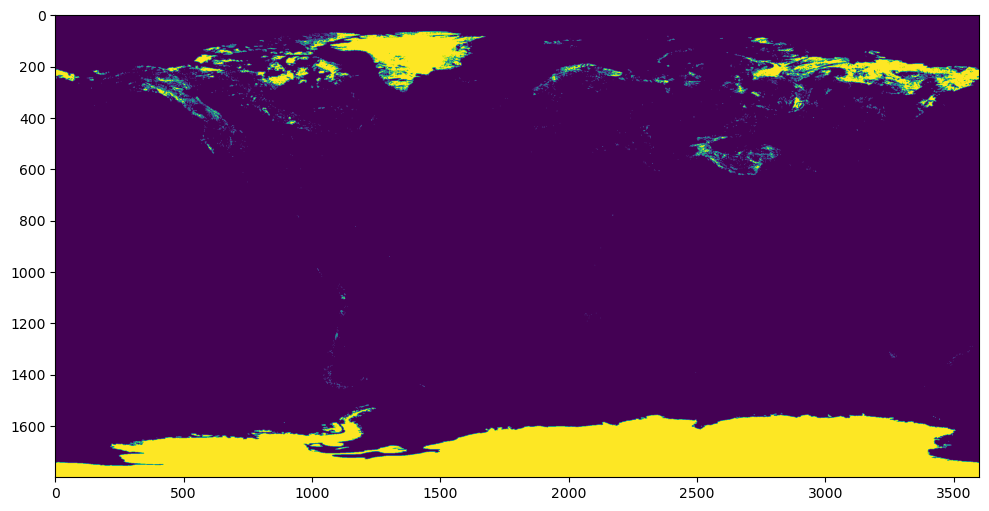

In [38]:
# another code for deriving binary snow mask 
save_mode = False
for name in os.listdir(your_current_dir+'/'):
    if 'MOD' in name:
        snow_map_path = your_current_dir+'/'+name   
f_b = nc.Dataset(snow_map_path)
Day_CMG_Snow_Cover = np.array(f_b['Day_CMG_Snow_Cover'])
Day_CMG_Clear_Index = np.array(f_b['Day_CMG_Clear_Index'])
Day_CMG_Cloud_Obscured = np.array(f_b['Day_CMG_Cloud_Obscured'])
Snow_Spatial_QA = np.array(f_b['Snow_Spatial_QA'])
Day_CMG_Snow_Cover[Day_CMG_Snow_Cover<50] = 0
Day_CMG_Snow_Cover[Day_CMG_Snow_Cover==107] = 100
Day_CMG_Snow_Cover[Day_CMG_Snow_Cover==252] = 100
Day_CMG_Snow_Cover[Day_CMG_Snow_Cover>100] = 0
Snow_Spatial_QA[Snow_Spatial_QA<=2] = 1
Snow_Spatial_QA[Snow_Spatial_QA==252] = 1
Snow_Spatial_QA[Snow_Spatial_QA!=1] = 0
Day_CMG_Cloud_Obscured[Day_CMG_Cloud_Obscured==252]=1
Day_CMG_Cloud_Obscured[Day_CMG_Cloud_Obscured>50]=0
Day_CMG_Cloud_Obscured[Day_CMG_Cloud_Obscured!=0]=1
file_path_bin = snow_map_path.replace('.hdf', '.tif')
binarized_snow = ((Day_CMG_Snow_Cover*Snow_Spatial_QA)/100*255).astype(np.uint8)
binarized_snow[binarized_snow!=0]=255
snow_map = np.array(Image.fromarray(binarized_snow).resize((3600,1800),resample=Image.NEAREST)).astype(np.uint8)
if save_mode:
    tff.imsave(file_path_bin,snow_map)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(snow_map)
plt.show()

#### **NOW WRAP STER GDEM TO THE GOES GEOSTATIONRY PROJECTION**

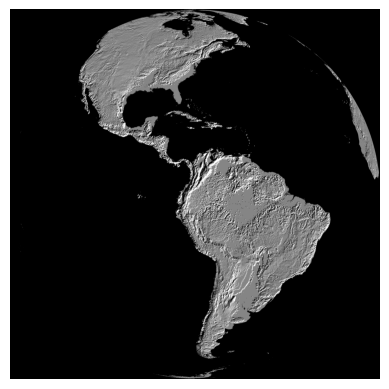

(5424, 5424)

In [39]:
if GOES_16_mode:
    sat_lon = -76.0
if GOES_17_mode:
    sat_lon = -137.0
plate_caree_crs = rasterio.crs.CRS.from_epsg(4326)
# Define Plate Carrée transform
aster_gdem_needed_resampled = interp_resize(aster_gdem_map, (3600//2,2*1800))
plate_caree_transform = rasterio.Affine(0.1, 0, -180, 0, -0.1, 90)
# Define the affine transformation coefficients for the geostationary projection
y_res = 2003 # 2 km resolution
x_res = 2003
goes16_transform = rasterio.Affine(x_res, 0, -5434894.675269887, 0, -y_res, 5434894.675269887)
# Define the geostationary projection CRS
goes16_crs = {'proj': 'geos', 
       'lon_0': sat_lon, 
       'h': 35786023.0,
        'a': 6378137.0,
        'b': 6356752.314, 
        'ellps': 'GRS80',
       'units': 'm',
        'sweep':'x',
       'no_defs': True}
# Define the output shape and resolution
out_shape = (5424, 5424)
out_transform = goes16_transform

# Reproject the plate caree snow map image to the geostationary projection

reprojected_alt_map = np.zeros(out_shape)
reproject(
    source=aster_gdem_needed_resampled,
    destination=reprojected_alt_map,
    src_transform=plate_caree_transform,
    src_crs=plate_caree_crs,
    dst_transform=goes16_transform,
    dst_crs=goes16_crs,
    resampling=Resampling.nearest)

# Visualize the reprojected snow map
plt.imshow(reprojected_alt_map, cmap='gray')
plt.axis('off')
plt.show()
if save_mode:
    tff.imsave(your_current_dir+'/DEM_reprojected.tif',(reprojected_alt_map*255).astype(np.uint8))

#### **REPEAT THE SAME WRAPPING FOR SNOW MAP FROM MODIS TERRA**

[  0 255]


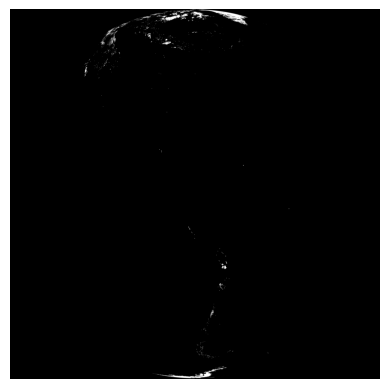

In [40]:
if GOES_16_mode:
    sat_lon = -76.0
if GOES_17_mode:
    sat_lon = -137.0
x_res = 2003
y_res = 2004
plate_caree_crs = rasterio.crs.CRS.from_epsg(4326)
plate_caree_transform = rasterio.Affine(0.1, 0, -180, 0, -0.1, 90)
goes16_transform = rasterio.Affine(x_res, 0, -5434894.675269887+5000, 0, -y_res, 5434894.675269887-4000)
goes16_crs = {'proj': 'geos', 
       'lon_0': sat_lon, 
       'h': 35786023.0,
        'a': 6378137.0,
        'b': 6356752.314, 
        'ellps': 'GRS80',
       'units': 'm',
        'sweep':'x',
       'no_defs': True}
snow_needed_resampled = interp_resize(snow_map, (3600//2,2*1800))
snow_needed_resampled = (snow_needed_resampled*255).astype(np.uint8)
print(np.unique(snow_needed_resampled))
out_shape = (5424, 5424)
out_transform = goes16_transform
reprojected_snow_map = np.zeros(out_shape)
reproject(
    source=snow_needed_resampled,
    destination=reprojected_snow_map,
    src_transform=plate_caree_transform,
    src_crs=plate_caree_crs,
    dst_transform=goes16_transform,
    dst_crs=goes16_crs,
    resampling=Resampling.nearest)
# Visualize the reprojected snow map
plt.imshow(reprojected_snow_map, cmap='gray')
plt.axis('off')
plt.show()
if save_mode:
    snow_path = your_current_dir+'/snow_reprojected.jpg'
    tff.imsave(snow_path,(reprojected_snow_map).astype(np.uint8))

**THIS CODE AND UTILS FOR PARSING AND REPROJECTING CAN BE EASILY ADAPTED FOR GOES-18, ELECTRO L1, L2 ,L3, L4 SATELLITES AS WELL, JUST CHANGING SAT LON POSITION, UTC TIME FOR ZSA CORRECTION, ADJUST CHANNEL NAMES AND RESOLUTION OF MULTISPECTRAL IMAGERY DATA**